In [22]:
import sys
sys.path.append('/Users/blandt/Documents/PhDWork/Code/polaritymodel')
from polaritymodel import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [52]:
class WP:
    def __init__(self, D=0.1, k0=0.067, gamma=1, K=1, delta=1, p0=2.45, xsteps=100, Tmax=1000, deltat=0.01, 
                 deltax=0.1):
        # Species
        self.U = np.zeros([int(xsteps)])
        self.time = 0

        # Diffusion
        self.D = D

        # Dosage
        self.p0 = p0

        # Membrane exchange
        self.k0 = k0
        self.gamma = gamma
        self.K = K
        self.delta = delta

        # Misc
        self.xsteps = int(xsteps)
        self.Tmax = Tmax  # s
        self.deltat = deltat  # s
        self.deltax = deltax  # um

    def dxdt(self, X):
        U = X[0]
        V = self.p0 - np.mean(U)
        dU = V * (self.k0 + (self.gamma * (U ** 2)) / ((self.K ** 2) + (U ** 2))) - (self.delta * U) + (
                self.D * diffusion(U, self.deltax))
        return [dU]

    def initiate(self):
        # Initial equilibration
        Tmax = self.Tmax / 10
        soln, time, solns, times = pdeRK(dxdt=self.dxdt, X0=[self.U], Tmax=Tmax, deltat=self.deltat,
                                         t_eval=np.arange(0, Tmax + 0.0001, Tmax))
        self.U = soln[0]

        # Polarise
        self.U *= 2 * np.r_[np.zeros([self.xsteps // 2]), np.ones([self.xsteps // 2])]

    def run(self, save_gap=None):
        if save_gap is None:
            save_gap = self.Tmax

        # Run
        soln, time, solns, times = pdeRK(dxdt=self.dxdt, X0=[self.U], Tmax=self.Tmax, deltat=self.deltat,
                                         t_eval=np.arange(0, self.Tmax + 0.0001, save_gap))
        self.U = soln[0]

        return soln, time, solns, times
    
def diffusion(concs, dx=1, pad=True):
    """
    Simulate single diffusion time step

    :param concs: 1D array of concentrations across space
    :param dx: spatial distance between points
    :return:
    """

    if pad:
        concs_ = np.r_[concs[0], concs, concs[-1]]
        d = concs_[:-2] - 2 * concs_[1:-1] + concs_[2:]
    else:
        d = concs[:-2] - 2 * concs[1:-1] + concs[2:]
    return d / (dx ** 2)

In [53]:
model = WP(D=0.1, k0=0.067, gamma=1, K=1, delta=1, xsteps=100, Tmax=1000, deltat=0.01, deltax=0.1)

model.initiate()
soln, time, _, _ = model.run()

<IPython.core.display.Javascript object>


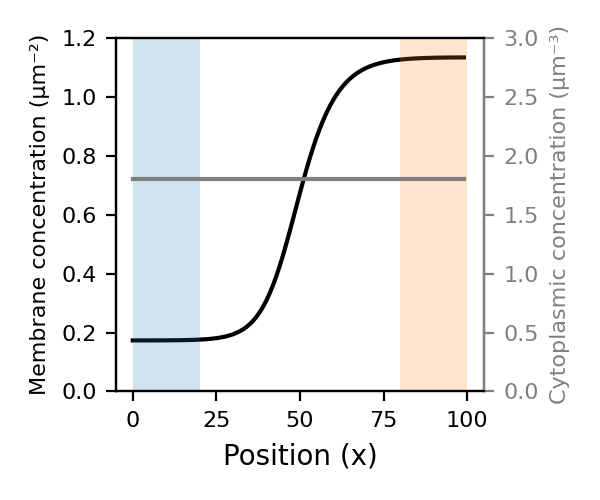

In [71]:
fig, ax2 = plt.subplots()
ax1 = ax2.twinx()
ax1.plot((model.p0 - np.mean(soln[0])) * np.ones(soln[0].shape), c='0.5')
ax2.plot(soln[0], c='k')
ax1.set_ylim(bottom=0, top=3)
ax2.set_ylim(bottom=0, top=1.2)
ax1.axvspan(0, 20, alpha=0.2, color='tab:blue', linewidth=0, zorder=0)
ax1.axvspan(80, 100, alpha=0.2, color='tab:orange', linewidth=0, zorder=0)
ax1.set_ylabel('Cytoplasmic concentration (μm⁻³)', fontsize=8, c='0.5')
ax1.spines['right'].set_color('0.5')
ax1.tick_params(axis='y', colors='0.5')
ax2.set_ylabel('Membrane concentration (μm⁻²)', fontsize=8)
ax2.set_xlabel('Position (x)')
ax1.tick_params(axis='both', labelsize=8)
ax2.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3, 2.5)
fig.tight_layout()
fig.savefig('Figs/pattern.png', dpi=600, transparent=True)

In [48]:
print(model.p0 - np.mean(soln[0]))
print(soln[0][0])
print(soln[0][-1])

1.8016206474100231
0.1731827821402167
1.1329176917468908
